# Cats vs Non-cats using Transfer Learning - What is Transfer Learning?

(This project was a part of **Machine Learning Specialization with TF2** by [**CLOUDXLAB**](http://cloudxlab.com/))

- Transfer learning has become so handy for computer vision geeks.

- It’s basically a mechanism where the knowledge acquired by training a model for achieving a task is efficiently modified or optimized in order to accomplish the second related task.

- For example, a neural network trained on object recognition can be used to read x-ray scans.

- This is achieved by freezing the weights until the initial or mid-layers are learned on the data for task A, removing the last layer or a few of the last layers, and adding new layers and training those parameters using the data for task B.

#  Why Transfer Learning?
The Transfer Learning technique is very useful because:

- Using a well-trained model which performs really great for task A, we can develop a model which performs elegantly for task B, though we have fewer data available for task B

- There are fewer parameters to be trained (only last layer/layers) and thus less training time,

- There is less demand for heavy computational resources like GPU, TPU (but still depends on the data available for task B).

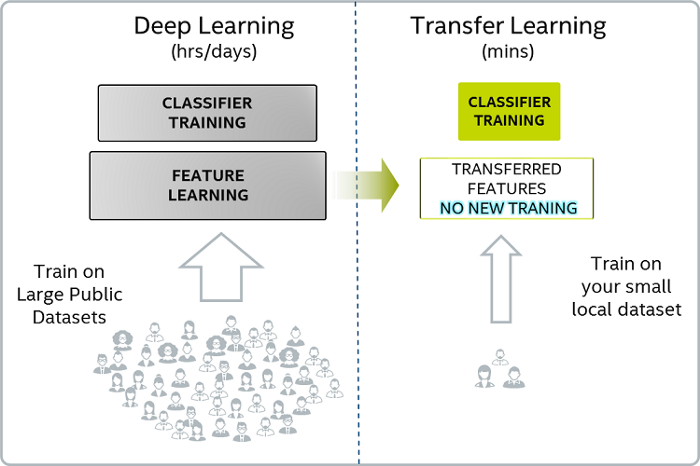

# How do we do Transfer Learning?
Transfer learning makes sense when the data in training for task A is quite large and that of task B is relatively smaller.

- By getting trained on such vast amounts of data and showing excellent performance on its test data, this implies that the neural network has a good knowledge of extracting useful features from the input images. This is essential and powerful for achieving a task.

- Now that we have such powerful features from these layers (whose weights from task A are frozen), we just need to make use of these extracted features to achieve task B. So, these features from frozen layers are fed to the new layers, and the parameters for these layers are trained on the data of task B.

So basically, we store the knowledge from the previous task in the form of the weights of the frozen layers **(called pre-training).** Then we make the neural network task B-specific by training **(called fine-tuning)** the latter layers on the new data.

- In our project, we will be using pre-trained models which were trained to classify a large set of images(which is the task A), and fine-tune it to make the classifier specific to our classification task of cats vs non-cats(which is task B).

# What are we going to do now?
- We are going to build a model to classify cats vs non-cats, using transfer learning.
- We are going to build it on top of the pre-trained VGG16 models.
- We shall use the weights of the model, and fine-tune it by adding some layers on top of that, in order to customize it for our own purpose - cat vs non-cat classification.
- We use the same weights of the CNNs by freezing them, and we remove the top(which are dense layers) to add our customized dense layers. The customized top dense layers are trained(which is known as fine-tuning), to make them especially learn about our data set.

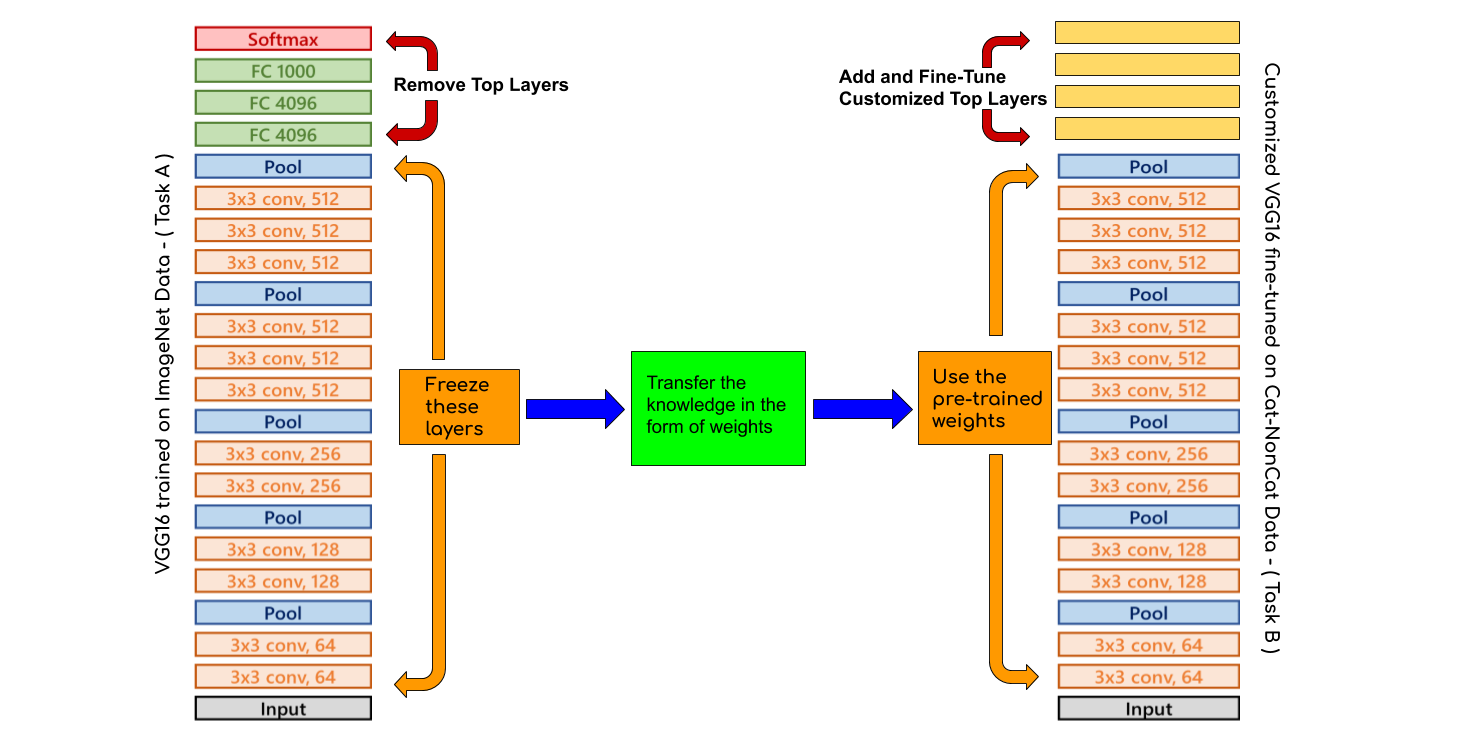

# The VGG16 Model
Firstly, let us know about the VGG16 model pre-trained on the Imagenet database.

- The VGG16 is a trained CNN primarily built to classify 1000 classes of the ImageNet database.

- It is built by using roughly 1.2 million training images, 50,000 validation images, and 150,000 testing images.

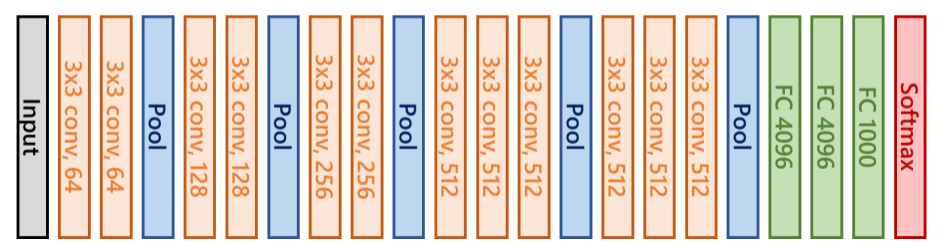

# Workflow

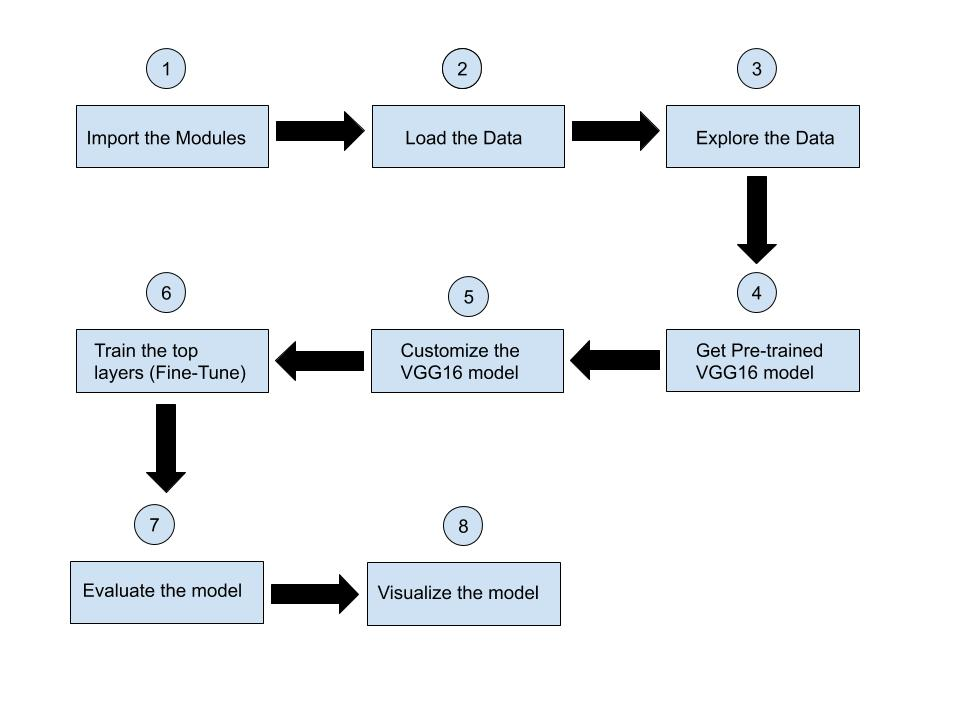

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorflow
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D

In [2]:
np.random.seed(42)
tensorflow.random.set_seed(42)

### About the Dataset
Dataset is located at /cxldata/datasets/project/cat-non-cat

Dataset is in .h5 file. It is a file format that could store the data - along with its meta-data - in the form of a hierarchy. Import h5py to interact with a dataset that is stored in an H5 file. It contains

train_catvnoncat.h5 - a training set of images labeled as cat (y=1) or non-cat (y=0)
test_catvnoncat.h5 - a test set of images labeled as cat or non-cat
Each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px) Now, let us load the dataset into our working session.

In [14]:
# load the data
train_dataset = h5py.File('/cxldata/datasets/project/cat-non-cat/train_catvnoncat.h5', "r")

test_dataset = h5py.File('/cxldata/datasets/project/cat-non-cat/test_catvnoncat.h5', "r")

print("File format of train_dataset:",train_dataset)
print("File format of test_dataset:",test_dataset)

File format of train_dataset: <HDF5 file "train_catvnoncat.h5" (mode r)>
File format of test_dataset: <HDF5 file "test_catvnoncat.h5" (mode r)>


In [15]:
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

Classes are:  [b'non-cat' b'cat']
Groundtruth stored as:  1
cat


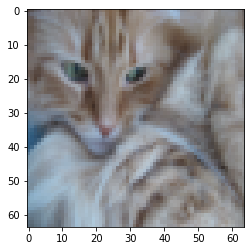

In [23]:
classes = np.array(test_dataset["list_classes"][:])

print("Classes are: ",classes)
print("Groundtruth stored as: ",train_set_y_orig[2])
print(classes[train_set_y_orig[2]].decode('utf-8'))

plt.imshow(train_set_x_orig[2])

In [26]:
# split the data
validation_x = test_set_x_orig[:25]
validation_y = test_set_y_orig[:25]

test_set_x = test_set_x_orig[25:]
test_set_y = test_set_y_orig[25:]

In [27]:
print("train_set_x shape: ", train_set_x_orig.shape)
print("train_set_y shape: ", train_set_y_orig.shape)

train_set_x shape:  (209, 64, 64, 3)
train_set_y shape:  (209,)


In [28]:
print("Validation data size: ", validation_x.shape)
print("Validation data size: ", validation_y.shape)

Validation data size:  (25, 64, 64, 3)
Validation data size:  (25,)


In [29]:
print("test_set_x shape: ", test_set_x.shape)
print("test_set_y shape: ", test_set_y.shape)

test_set_x shape:  (25, 64, 64, 3)
test_set_y shape:  (25,)


### Getting Pre-Trained VGG16 base model
The trained VGG16 model is available with tensorflow.keras.applications. We have imported this as from tensorflow.keras.applications import VGG16 in the Import Modules section.

Now let us see how we could use.

In [43]:
vgg_base = VGG16(weights='imagenet', include_top=False)

vgg_base.trainable=False

58892288/58889256 [==============================] - 1s 0us/step


### Explanation:

We have got an instance of the VGG16 model which is trained on 'imagenet' data.

Since we want to customize it for our purpose of cat-vs-noncat classification, we remove the top layers which are the dense layers.

We put the vgg_base layers are not trainable by setting vgg_base to False, so that we could use the same weights of the Convolutional layers as used in the VGG16 imagenet data.

In [48]:
# customize vgg16 model

inp = Input(shape=(64, 64, 3), name='image_input')

In [49]:
#initiate a model
vgg_model = Sequential()

In [50]:
#Add the VGG base model
vgg_model.add(vgg_base)

In [51]:
vgg_model.add(GlobalAveragePooling2D())

vgg_model.add(Dense(1024,activation='relu'))
vgg_model.add(Dropout(0.6))

vgg_model.add(Dense(512,activation='relu'))
vgg_model.add(Dropout(0.5))

vgg_model.add(Dense(1024,activation='relu'))
vgg_model.add(Dropout(0.4))

vgg_model.add(Dense(1024,activation='relu'))
vgg_model.add(Dropout(0.3))

vgg_model.add(Dense(1, activation='sigmoid'))

In [56]:
sgd = SGD(lr=0.025)

### Compile the VGG16 model
In addition to adding the custom dense layers to train, we should also mention some other factors like:

the optimization algorithm
learning rate
loss function
metrics of evaluation and others.

In [57]:
vgg_model.compile(loss= "binary_crossentropy", optimizer=sgd, metrics=['accuracy'])

### Training the Top Layers of the VGG16 model
We shall now fit the model.

In [62]:
vgg_model.fit(train_set_x_orig, train_set_y_orig, epochs=10, verbose=1, validation_data=(validation_x, validation_y))

Train on 209 samples, validate on 25 samples
Epoch 1/10
209/209 [==============================] - 3s 14ms/sample - loss: 27.8695 - accuracy: 0.5263 - val_loss: 0.5230 - val_accuracy: 0.7600
Epoch 2/10
209/209 [==============================] - 1s 7ms/sample - loss: 0.6574 - accuracy: 0.6651 - val_loss: 0.5303 - val_accuracy: 0.6400
Epoch 3/10
209/209 [==============================] - 1s 7ms/sample - loss: 0.7430 - accuracy: 0.7081 - val_loss: 0.3530 - val_accuracy: 0.7600
Epoch 4/10
209/209 [==============================] - 1s 7ms/sample - loss: 0.4528 - accuracy: 0.8373 - val_loss: 0.2090 - val_accuracy: 1.0000
Epoch 5/10
209/209 [==============================] - 1s 7ms/sample - loss: 0.3711 - accuracy: 0.8517 - val_loss: 0.1913 - val_accuracy: 0.9600
Epoch 6/10
209/209 [==============================] - 1s 7ms/sample - loss: 0.2834 - accuracy: 0.8708 - val_loss: 0.1721 - val_accuracy: 0.9600
Epoch 7/10
209/209 [==============================] - 1s 7ms/sample - loss: 0.2183 - accu

### Evaluating the VGG16 model on test data
Since we have fine-tuned the model by training our custom dense layers on our data, let us check the performance of the model.

In [65]:
vgg_model_loss, vgg_model_acc = vgg_model.evaluate(test_set_x_orig,test_set_y_orig)

50/50 [==============================] - 0s 6ms/sample - loss: 0.2468 - accuracy: 0.8800


In [66]:
print('Test accuracy using VGG16 model as the base:', vgg_model_acc)

Test accuracy using VGG16 model as the base: 0.88


In [70]:
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [72]:
from tensorflow.keras.utils import plot_model

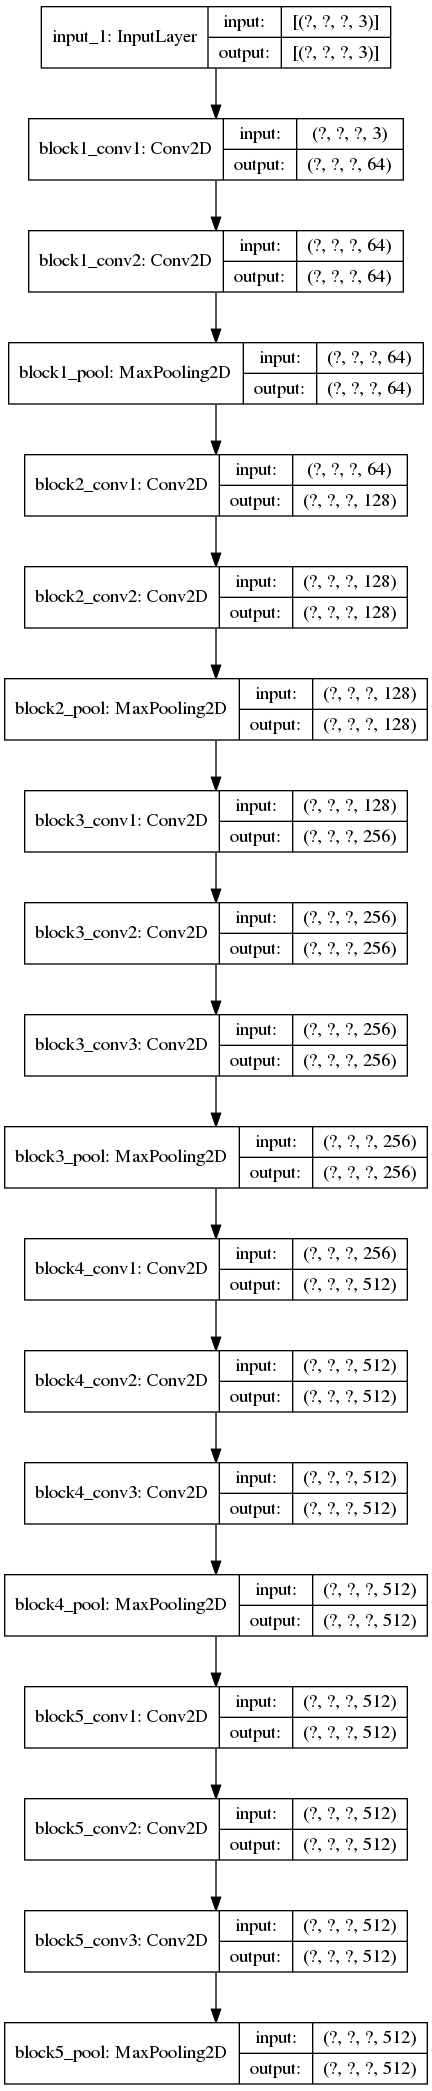

In [73]:
plot_model(vgg_base, show_shapes=True, show_layer_names=True)

In [74]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              5

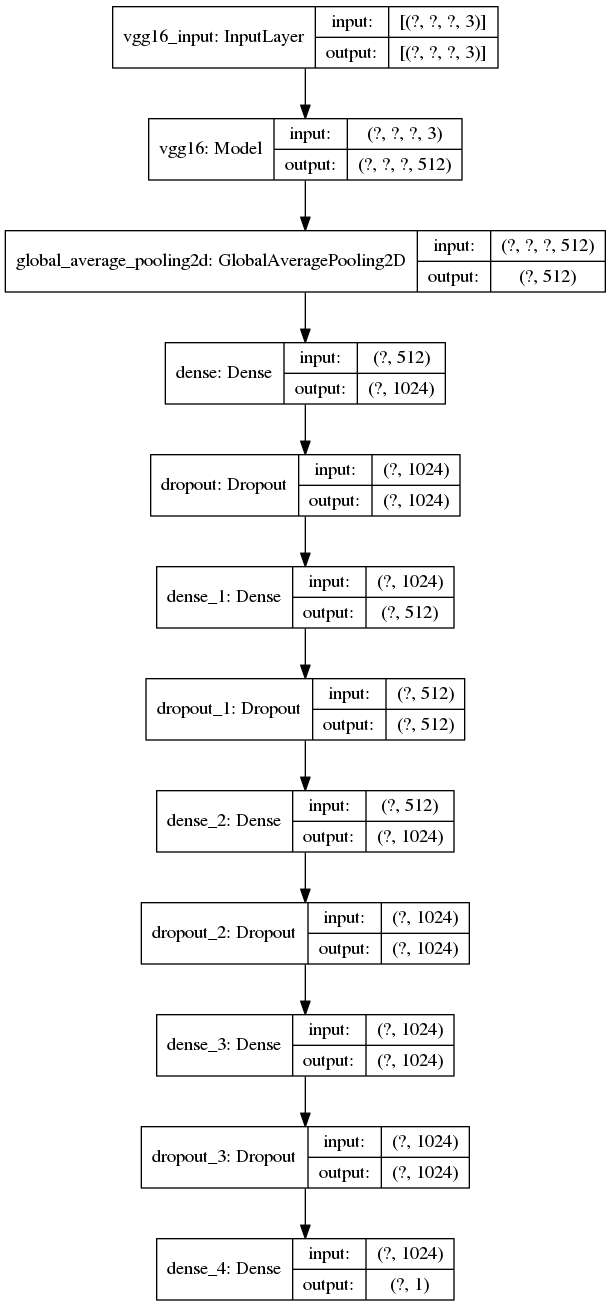

In [75]:
plot_model(vgg_model, show_shapes=True, show_layer_names=True)